<a href="https://colab.research.google.com/github/irishask/Advanced_EDA/blob/main/Main_Census_with_wisualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Drive-get files:

In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Get the file:
downloadedTrue = drive.CreateFile({'id':"1eT_5AlOA8jrGVR7oVImfi5dIzD4uGM1-"})   # replace the id with id of file you want to access
downloadedTrue.GetContentFile('Show_Graphs.py')        # replace the file name with your file

downloadedTrue = drive.CreateFile({'id':"1AXHXnaNrqDKX7xuLUPcK_7JtoQKmfejB"})   # replace the id with id of file you want to access
downloadedTrue.GetContentFile('US_states.py')        # replace the file name with your file

In [2]:
import pandas as pd
import censusdata as cs
import re
from scipy import stats
import US_states
import Show_Graphs

# General Function -  display options for pandas:
For all display options=>  https://pandas.pydata.org/pandas-docs/version/0.22/options.html

In [3]:
def display_options_for_pandas():
    # pd.set_option('display.max_rows', 500)
    pd.set_option('display.max_columns', 500)
    pd.set_option('max_colwidth',
                  100)  # Sets the maximum width of columns. Cells of this length or longer will be truncated with an ellipsis.
    pd.set_option('display.width', 500000)
    pd.set_option('column_space', 120)
    pd.set_option('precision', 4)  # sets the output display precision in terms of decimal places
    pd.get_option("display.max_row", 1000)
    # pd.set_option("display.max_rows", 101)  #default = 500
    pd.set_option('max_info_columns', 10)

    # Reset ALL display options:
    # pd.reset_option("^display")
    # Reset wanted display option:
    # pd.reset_option('display.width')
    return

### Common method for both questions - adding columns 'State_name', 'State_code' and 'State_abbr' to the dataframe:

In [3]:
def Add_US_state_details_as_a_columns_to_df(df):
    # Reset index to make from it a regular column. New index will be a default index (=0,1,...).
    df.reset_index(inplace=True)
    df_orig_index_list = str(df['index']).split("\n")
    # print(df_orig_index_list)

    # Builds dictionary 'state_dict' = {state_name: state_code}
    state_dict = {}
    i = 0
    for var in df_orig_index_list:
        i += 1
        # Exclude the last item (it's NOT a state)
        if (i == len(df_orig_index_list)):
            break
        # Remove unnecessary sub-string:
        var_new = re.sub(': Summary level: 040, state:', ',', var)
        var_new = re.sub(':Summarylevel:040,state', ',', var_new)
        var_new = re.sub(': Summary level: 040, stat...', ',11',
                         var_new)  # for 'DistrictofColumbia' only!  =>  SET state_code ='11'

        # Get state_name and state_codeber:
        state_name = var_new[3:-3]
        state_code = var_new[-2:]
        # Add to dictionary. To remove all spaces in the beginning of 'state_name' use => state_name.strip():
        state_dict.update({state_name.strip(): state_code})
    # print (f"state_dict={state_dict})")

    # Create df from the list & rename a column
    df_states_unsorted = pd.DataFrame(state_dict.keys(), columns=['State'])
    df_code_unsorted   = pd.DataFrame(state_dict.values(), columns=['State_code'])
    df_states_and_code_unsorted = pd.concat([df_states_unsorted, df_code_unsorted], axis=1, sort=False)
    # print(f"df_states_and_code_unordered:\n{df_states_and_code_unordered}")

    # Create instance of 'US_States' to build df which contains 'state_name', 'state_code' and 'state_abbreviation' for every State in Census_table
    us_states = US_states.US_States(df_states_and_code_unsorted)
    df_states_code_abbr_unsorted = us_states.df_census_states_abbr
    # print(f"df_states_code_abbr_unsorted:\n{df_states_code_abbr_unsorted}")

    # Delete first column:
    df.drop(columns=['index'], axis=1, inplace=True)

    # Concate dataframes to the final result:
    result = pd.concat([df_states_code_abbr_unsorted, df], axis=1, sort=False)
    # print("Current Index:\n", result.index.tolist())
    # print ("result:\n", result)
    return (result)


# Q1: Top 20 US-states where is the highest percentage of Foreign-born with the high income (65+K) out of total_FB VS Natives the high income (65+K) out of total_Natives.
### Click on a bar to see details of income diversity for Natives/FB (in %) for the specific State.


In [5]:
# Percent of People with income from Total, Mix of 35K+ Income from Total, Same measures for Foreing Birth only, 2017
def Download_and_Modify_for_ForeingBorn_vs_NativeStates_Income():
    income_by_states = cs.download('acs5', 2017, cs.censusgeo([('state', '*')]),
                                   ['B06010_001E', 'B06010_003E',
                                    'B06010_008E', 'B06010_009E',
                                    'B06010_010E', 'B06010_011E',
                                    'B06010_045E', 'B06010_047E',
                                    'B06010_052E', 'B06010_053E',
                                    'B06010_054E', 'B06010_055E',
                                    ])
    # Rename columns:
    income_by_states = income_by_states.rename(columns={
        'B06010_001E': 'Total',
        'B06010_003E': 'With_Income',
        'B06010_008E': '35_50_K',
        'B06010_009E': '50_65_K',
        'B06010_010E': '65_75_K',
        'B06010_011E': '75K_More',
        'B06010_045E': 'FB_Total',  # FB = Foreign Born
        'B06010_047E': 'FB_With_Income',
        'B06010_052E': 'FB_35_50_K',
        'B06010_053E': 'FB_50_65_K',
        'B06010_054E': 'FB_65_75_K',
        'B06010_055E': 'FB_75K_More',
    })

    # Add 'State_name', 'State_code' and 'State_abbr' to downloaded dataframe:
    income_by_states = Add_US_state_details_as_a_columns_to_df(income_by_states)
    # .dropna(how ='any') => drop all rows with any 'NaN' values:
    income_by_states = income_by_states.dropna(axis=0, how='any')
    # print("Income_by_states:\n", income_by_states)
    return (income_by_states)


In [6]:
# DOES NOT WORK AFTER THE LAST UPDATES!!!
def Graphs_with_OnClickEvents(income_by_states):
    # 2.1 - Show the 25 US-states with the highest percentage of 'With Income' out of Total state population:
    top_20_incomes_OutOfAll = income_by_states.sort_values(['FB_65K_More_from_All%', 'NO_65_More_from_All%'],
                                                           ascending=False, inplace=False).head(25)
    # print(f"\n 25 US-states with the highest percentage of 'With Income' for ALL_citizens and for FB_only: \n {top_ten_incomes}")

    top_65K_More_incomes_OutOfAll = zip(top_20_incomes_OutOfAll['State_abbr'],
                                        round(top_20_incomes_OutOfAll['NO_65_More_from_All%'] * 100, 1),
                                        round(top_20_incomes_OutOfAll['FB_65K_More_from_All%'] * 100, 1))
    # print(f"top_ten_65K_More:\n {top_ten_65K_More}")
    headers = ['State_abbr', 'NO_65_More_from_All%', 'FB_65K_More_from_All%']
    top_65K_More_incomes_OutOfAll = pd.DataFrame(top_65K_More_incomes_OutOfAll, columns=headers)
    # print(f"df_top_ten_65K_More:\n {df_top_20_65K_More}")

    Show_Graphs.PairedBar_withValues_df(
        df=top_65K_More_incomes_OutOfAll,
        labels="State_abbr",
        col_bar1="NO_65_More_from_All%",
        col_bar2="FB_65K_More_from_All%",
        label_bar1='Natives with 65+K out of total population(%)',
        label_bar2='ForeignBorn with 65+K out of total population(%)',
        y_title='Percent of NO/FB out of total state population',
        graph_title='Top 25 US-states Foreign born with Income 65+K VS Natives with Income 65+K in these states out of Total state population',
        color1="#f77e55",
        color2="#41e396"
    )

    # ----------------------
    # 2.2- Show the 25 US-states with the highest percentage of 'With Income' out of Native/Forighn Born populations ():
    top_20_incomes_OutOf_categ = income_by_states.sort_values(['FB_65K_More_from_FB%', 'NO_65_More_from_NO%'],
                                                              ascending=False, inplace=False).head(20)
    print(
        f"\n 20 US-states with the highest percentage of 'With Income' for ALL_citizens and for FB_only: \n {top_20_incomes_OutOf_categ}")

    top_65K_More_incomes_OutOf_categ = zip(top_20_incomes_OutOf_categ['State_abbr'],
                                           top_20_incomes_OutOf_categ['FB_35_50_K_from_FB%'],
                                           top_20_incomes_OutOf_categ['FB_50_65_K_from_FB%'],
                                           top_20_incomes_OutOf_categ['FB_65_75_K_from_FB%'],
                                           top_20_incomes_OutOf_categ['FB_75K_More_from_FB%'],
                                           top_20_incomes_OutOf_categ['NO_35_50_K_from_NO%'],
                                           top_20_incomes_OutOf_categ['NO_50_65_K_from_NO%'],
                                           top_20_incomes_OutOf_categ['NO_65_75_K_from_NO%'],
                                           top_20_incomes_OutOf_categ['NO_75K_More_from_NO%'],
                                           round(top_20_incomes_OutOf_categ['NO_65_More_from_NO%'] * 100, 1),
                                           round(top_20_incomes_OutOf_categ['FB_65K_More_from_FB%'] * 100, 1)
                                           )
    # print(f"top_ten_65K_More:\n {top_65K_More_incomes_OutOf_categ}")

    headers = ['State_abbr',
               'NO_35_50_K_from_NO%', 'NO_50_65_K_from_NO%', 'NO_65_75_K_from_NO%', 'NO_75K_More_from_NO%',
               'FB_35_50_K_from_FB%', 'FB_50_65_K_from_FB%', 'FB_65_75_K_from_FB%', 'FB_75K_More_from_FB%',
               'NO_65_More_from_NO%', 'FB_65K_More_from_FB%']
    df_top_65K_More_OutOf_categ = pd.DataFrame(top_65K_More_incomes_OutOf_categ, columns=headers)

    print(f"df_top_ten_65K_More:\n {df_top_65K_More_OutOf_categ}")

    Show_Graphs.PairedBar_withValues_withOnClick_df(
        df=df_top_65K_More_OutOf_categ,
        labels="State_abbr",
        col_bar1="NO_65_More_from_NO%",
        col_bar2="FB_65K_More_from_FB%",
        label_bar1='Natives with 65+K out of total Natives(%)',
        label_bar2='ForeignBorn with 65+K out of total ForeignBorns(%)',
        y_title='Percent of NO/FB out of all NO/FB population',
        graph_title='Top 20 US-states where is the highest percentage of Foreign-born with Income 65+K out of total_FB VS Natives with Income 65+K out of total_Natives.'
                    '\n**Click on a bar to see details of income diversity for Natives/FB (in %) for the specific State**',
        color1="#4B328A",
        color2="#31A354"
    )
    return

In [7]:
def ForeingBorn_vs_Native_Incomes_by_states_2017_with_graph():
    # 1 - Download data from Census to dataframe and modify it:
    income_by_states = Download_and_Modify_for_ForeingBorn_vs_NativeStates_Income()

    # NO = Native Only
    income_by_states['NO_total'] = income_by_states['Total'] - income_by_states['FB_Total']  # NO = NativesOnly
    # income_by_states['FB_from_total_%'] = income_by_states['FB_Total'] / income_by_states['Total']
    # income_by_states['NO_total_%'] = income_by_states['NO_total'] / income_by_states['Total']
    income_by_states['NO_With_Income'] = income_by_states['With_Income'] - income_by_states['FB_With_Income']

    income_by_states['With_Income_All_%'] = income_by_states['With_Income'] / income_by_states['Total']
    income_by_states['NO_With_Income_from_All_%'] = income_by_states['NO_With_Income'] / income_by_states['Total']
    income_by_states['FB_With_Income_from_All_%'] = income_by_states['FB_With_Income'] / income_by_states['Total']

    income_by_states['With_Income_FB_from_FB%'] = income_by_states['FB_With_Income'] / income_by_states['FB_Total']
    income_by_states['With_Income_NO_from_NO%'] = income_by_states['NO_With_Income'] / income_by_states['NO_total']

    # Categories by income:
    income_by_states['NO_35_50_K']  = income_by_states['35_50_K'] - income_by_states['FB_35_50_K']
    income_by_states['NO_50_65_K']  = income_by_states['50_65_K'] - income_by_states['FB_50_65_K']
    income_by_states['NO_65_75_K']  = income_by_states['65_75_K'] - income_by_states['FB_65_75_K']
    income_by_states['NO_75K_More'] = income_by_states['75K_More'] - income_by_states['FB_75K_More']

    income_by_states['NO_65_More_from_All%'] = (income_by_states['NO_65_75_K'] + income_by_states['NO_75K_More']) / \
                                               income_by_states['NO_With_Income'] * income_by_states[
                                                   'NO_With_Income_from_All_%']
    income_by_states['FB_65K_More_from_All%'] = (income_by_states['FB_65_75_K'] + income_by_states['FB_75K_More']) / \
                                                income_by_states['FB_With_Income'] * income_by_states[
                                                    'FB_With_Income_from_All_%']

    income_by_states['NO_65_More_from_NO%'] = (income_by_states['NO_65_75_K'] + income_by_states['NO_75K_More']) / \
                                              income_by_states['NO_With_Income'] * income_by_states[
                                                  'With_Income_NO_from_NO%']
    income_by_states['FB_65K_More_from_FB%'] = (income_by_states['FB_65_75_K'] + income_by_states['FB_75K_More']) / \
                                               income_by_states['FB_With_Income'] * income_by_states[
                                                   'With_Income_FB_from_FB%']

    income_by_states['NO_35_50_K_from_NO%'] = income_by_states['NO_35_50_K'] / income_by_states['NO_With_Income'] * \
                                              income_by_states['With_Income_NO_from_NO%']
    income_by_states['NO_50_65_K_from_NO%'] = income_by_states['NO_50_65_K'] / income_by_states['NO_With_Income'] * \
                                              income_by_states['With_Income_NO_from_NO%']
    income_by_states['NO_65_75_K_from_NO%'] = income_by_states['NO_65_75_K'] / income_by_states['NO_With_Income'] * \
                                              income_by_states['With_Income_NO_from_NO%']
    income_by_states['NO_75K_More_from_NO%'] = income_by_states['NO_75K_More'] / income_by_states['NO_With_Income'] * \
                                               income_by_states['With_Income_NO_from_NO%']

    income_by_states['FB_35_50_K_from_FB%'] = income_by_states['FB_35_50_K'] / income_by_states['FB_With_Income'] * \
                                              income_by_states['With_Income_FB_from_FB%']
    income_by_states['FB_50_65_K_from_FB%'] = income_by_states['FB_50_65_K'] / income_by_states['FB_With_Income'] * \
                                              income_by_states['With_Income_FB_from_FB%']
    income_by_states['FB_65_75_K_from_FB%'] = income_by_states['FB_65_75_K'] / income_by_states['FB_With_Income'] * \
                                              income_by_states['With_Income_FB_from_FB%']
    income_by_states['FB_75K_More_from_FB%'] = income_by_states['FB_75K_More'] / income_by_states['FB_With_Income'] * \
                                               income_by_states['With_Income_FB_from_FB%']
    print(income_by_states)

    ## Build Graphs ---------------
    # Graphs_for_ForeingBorn_vs_Native_Incomes(income_by_states)
    Graphs_with_OnClickEvents(income_by_states)

    return (income_by_states)


# Q2: Difference between the absorption of the population in different US-states:

In [4]:
# Get Percent of Naturalization (US-citizenship which is granted to foreign citizens) by States for 2017
def Download_and_Modify_citizenship_by_states():
    citizenship_by_states = cs.download('acs5', 2017, cs.censusgeo([('state', '*')]),
                                        ['B05001_001E', 'B05001_002E',
                                         'B05001_003E', 'B05001_004E',
                                         'B05001_005E', 'B05001_006E',
                                         'B05006_080E', 'B05006_078E'
                                         ])

    citizenship_by_states = citizenship_by_states.rename(columns={'B05001_001E': 'total',
                                                                  'B05001_002E': 'us_born_us',
                                                                  'B05001_003E': 'us_born_us_islands',
                                                                  'B05001_004E': 'us_born_abroad',
                                                                  'B05001_005E': 'us_by_naturalization',
                                                                  'B05001_006E': 'not_us_citizen',
                                                                  'B05006_078E': 'western_asia_born',
                                                                  'B05006_080E': 'israel_born',
                                                                  })

    # Adding columns 'state_name', 'state_code' and 'state_abbreviation' to current dataframe:
    citizenship_by_states = Add_US_state_details_as_a_columns_to_df(citizenship_by_states)
    # Remove empty observations with empty values:
    citizenship_by_states = citizenship_by_states.dropna(axis=0, how='any')
    return (citizenship_by_states)

In [5]:
def Test_Significance_with_Pvalue(df, Prior, col_to_calc_Avg, binom_col, binom_total_col, val_to_print, alpha_val=0.05):
    # Calculate the difference between AVG (for each state) && Add these values as a new column:
    df["Diff_from_AVG_%"] = round((df[col_to_calc_Avg] - Prior) * 100, 3)  # Float with 3 digits + present as %
    df.sort_values(by="Diff_from_AVG_%", ascending=False, inplace=True)
    # print("\n3-Including 'Diff_from_AVG_%':\n", citizenship_by_states.style.applymap(display_color_negative_red(citizenship_by_states["Diff_from_AVG_%"])))

    # Calculate the "p_value" (= Significance\Muvhakut) for each state && Add these values as a new column "p_value" to dataframe:
    # Check how much is the difference between AVG to current state =>  as the "p_value" higher => so 'muvhakut' is higher
    # scipy.stats.binom_test(x, n=None, p=0.5, alternative='two-sided')[source]  => Perform a test that the probability of success is p.
    #                       x (integer or array_like) = the number of successes
    #                       n (integer) = the number of trials.
    #                       p = probability of success.
    #                       alternative:{‘two-sided’, ‘greater’, ‘less’} = Indicates the alternative hypothesis (The default value is ‘two-sided’)
    # Returns the 'p_value' of the hypothesis test:
    df["p_value"] = df.apply(lambda row_b:
                             stats.binom_test(row_b[binom_col], row_b[binom_total_col], p=Prior,
                                              alternative="two-sided"),
                             axis=1)
    # print("\n4- Including 'P_VALUE' of ‘two-sided’ hypothesis test:\n", citizenship_by_states)

    # If (p_value>alpha) => Significantly Different; Else => Not Significantly different
    alpha = alpha_val
    no = df[df.p_value > alpha]
    yes = df[df.p_value <= alpha]
    print(
        f"Significant difference: \n\t{list(yes[val_to_print])} \nInsignificant difference: \n\t{list(no[val_to_print])}")
    return


In [6]:
def Graphs_for_ForeingBorn_vs_Native_Incomes(income_by_states):
    # 2.1 - Show the 25 US-states with the highest percentage of 'With Income' out of Total state population:
    top_20_incomes = income_by_states.sort_values(['FB_65K_More_from_All%', 'NO_65_More_from_All%'], ascending=False,
                                                  inplace=False).head(25)
    # print(f"\n 25 US-states with the highest percentage of 'With Income' for ALL_citizens and for FB_only: \n {top_ten_incomes}")

    top_20_65K_More = zip(top_20_incomes['State_abbr'],
                          round(top_20_incomes['NO_65_More_from_All%'] * 100, 1),
                          round(top_20_incomes['FB_65K_More_from_All%'] * 100, 1))
    # print(f"top_ten_65K_More:\n {top_ten_65K_More}")
    headers = ['State_abbr', 'NO_65_More_from_All%', 'FB_65K_More_from_All%']
    df_top_20_65K_More = pd.DataFrame(top_20_65K_More, columns=headers)
    print(f"df_top_ten_65K_More:\n {df_top_20_65K_More}")

    Show_Graphs.PairedBar_withValues_df(
        df=df_top_20_65K_More,
        labels="State_abbr",
        col_bar1="NO_65_More_from_All%",
        col_bar2="FB_65K_More_from_All%",
        label_bar1='Natives with 65+K out of total population(%)',
        label_bar2='ForeignBorn with 65+K out of total population(%)',
        y_title='Percent of NO/FB out of total state population',
        graph_title='Top 25 US-states Foreign born with Income 65+K VS Natives with Income 65+K in these states out of Total state population',
        color1="#4B328A",
        color2="#31A354"
    )
    # ----------------------
    # 2.2- Show the 25 US-states with the highest percentage of 'With Income' out of Native/Forighn Born populations ():
    top_20_incomes = income_by_states.sort_values(['FB_65K_More_from_FB%', 'NO_65_More_from_NO%'], ascending=False,
                                                  inplace=False).head(20)
    # print(f"\n 25 US-states with the highest percentage of 'With Income' for ALL_citizens and for FB_only: \n {top_ten_incomes}")

    top_20_65K_More = zip(top_20_incomes['State_abbr'],
                          round(top_20_incomes['NO_65_More_from_NO%'] * 100, 1),
                          round(top_20_incomes['FB_65K_More_from_FB%'] * 100, 1))
    # print(f"top_ten_65K_More:\n {top_ten_65K_More}")
    headers = ['State_abbr', 'NO_65_More_from_NO%', 'FB_65K_More_from_FB%']
    df_20_ten_65K_More = pd.DataFrame(top_20_65K_More, columns=headers)
    print(f"df_top_ten_65K_More:\n {df_20_ten_65K_More}")

    Show_Graphs.PairedBar_withValues_df(
        df=df_20_ten_65K_More,
        labels="State_abbr",
        col_bar1="NO_65_More_from_NO%",
        col_bar2="FB_65K_More_from_FB%",
        label_bar1='Natives with 65+K out of total Natives(%)',
        label_bar2='ForeignBorn with 65+K out of total ForeignBorns(%)',
        y_title='Percent of NO/FB out of all NO/FB population',
        graph_title='Top 20 US-states where Foreign-born with Income 65+K out of total_FB VS Natives with Income 65+K out of total_Natives',
        color1="#f77e55",
        color2="#41e396")
    return


In [7]:
def Graph_for_citizenship_by_states(citizenship_by_states):
    for col in citizenship_by_states.columns:
        citizenship_by_states[col] = citizenship_by_states[col].astype(str)

    # Add column to DataFrame with Text to present on the Graph:
    citizenship_by_states['text'] = 'State: ' + citizenship_by_states['State'] + '<br>' + \
                                    'Total population: ' + citizenship_by_states['total'] + '<br>' + \
                                    'Percent of Naturalization: ' + citizenship_by_states[
                                        'nat_not_us_%'] + '%' + '<br>' + \
                                    'Diff from Average: ' + citizenship_by_states['Diff_from_AVG_%'] + '%' + '<br>'
    print("Test\n", citizenship_by_states)

    Show_Graphs.US_Map_with_Text(df=citizenship_by_states,
                                 Zval_to_present_on_graph='nat_not_us_%',
                                 locations_val='State_abbr',
                                 color_base='Blues',
                                 text_on_select=citizenship_by_states['text'],
                                 cbar_title="Percent of Naturalization")
    return

In [8]:
def CitizenshipNaturalization_from_StatePopulation_2017_with_graph():
    # 1 - Download data from Census to dataframe and modify it:
    citizenship_by_states = Download_and_Modify_citizenship_by_states()

    # 2- Calculate the Percentage of Naturalized US-citizens with non US-citizen from Total State Population:
    citizenship_by_states['nat_not_us'] = citizenship_by_states['us_by_naturalization'] + citizenship_by_states[
        'not_us_citizen']
    citizenship_by_states['nat_not_us_%'] = round(
        citizenship_by_states['nat_not_us'] / citizenship_by_states['total'] * 100, 3)

    # Selecting features:
    citizenship_by_states = citizenship_by_states[
        ['State', 'State_code', 'State_abbr', 'total', 'nat_not_us', 'nat_not_us_%']]
    # print("\n2-After modernizations:\n", citizenship_by_states.head(10))

    # 3- Calculate Percent of all US-citizens who weren't born as US_citizens => (not_us_citizens + us_by_naturalization)/total
    Prior = citizenship_by_states['nat_not_us'].sum() / citizenship_by_states['total'].sum()
    print(f"\nAVG Percent of all Foreign Born citizens of US = {round(Prior, 3)}")

    # 4- Statistical exam of Significant Difference (by using P-value):
    Test_Significance_with_Pvalue(df=citizenship_by_states,
                                  Prior=Prior,
                                  col_to_calc_Avg='nat_not_us_%',
                                  binom_col='nat_not_us',
                                  binom_total_col='total',
                                  val_to_print='State_abbr',
                                  alpha_val=0.00001
                                  )
    # 5 - Show graph (new Window will be opened):
    Graph_for_citizenship_by_states(citizenship_by_states)

    return (citizenship_by_states)  # Return Modified dataframe (by dropping the original df)



# **MAIN**

In [ ]:
display_options_for_pandas()

Q1: States Income: Foreign born vs. Natives.
Close graphs to allow the program to continue running.
                   State State_code State_abbr       Total  With_Income    35_50_K    50_65_K    65_75_K   75K_More    FB_Total  FB_With_Income  FB_35_50_K  FB_50_65_K  FB_65_75_K  FB_75K_More    NO_total  NO_With_Income  With_Income_All_%  NO_With_Income_from_All_%  FB_With_Income_from_All_%  With_Income_FB_from_FB%  With_Income_NO_from_NO%  NO_35_50_K  NO_50_65_K  NO_65_75_K  NO_75K_More  NO_65_More_from_All%  FB_65K_More_from_All%  NO_65_More_from_NO%  FB_65K_More_from_FB%  NO_35_50_K_from_NO%  NO_50_65_K_from_NO%  NO_65_75_K_from_NO%  NO_75K_More_from_NO%  FB_35_50_K_from_FB%  FB_50_65_K_from_FB%  FB_65_75_K_from_FB%  FB_75K_More_from_FB%
1                Alabama         01         AL  3.9414e+06   3.3605e+06   450574.0   300156.0   114417.0   357336.0  1.5766e+05        121847.0     13476.0      9302.0      3565.0      15182.0  3.7837e+06      3.2386e+06             0.8526          

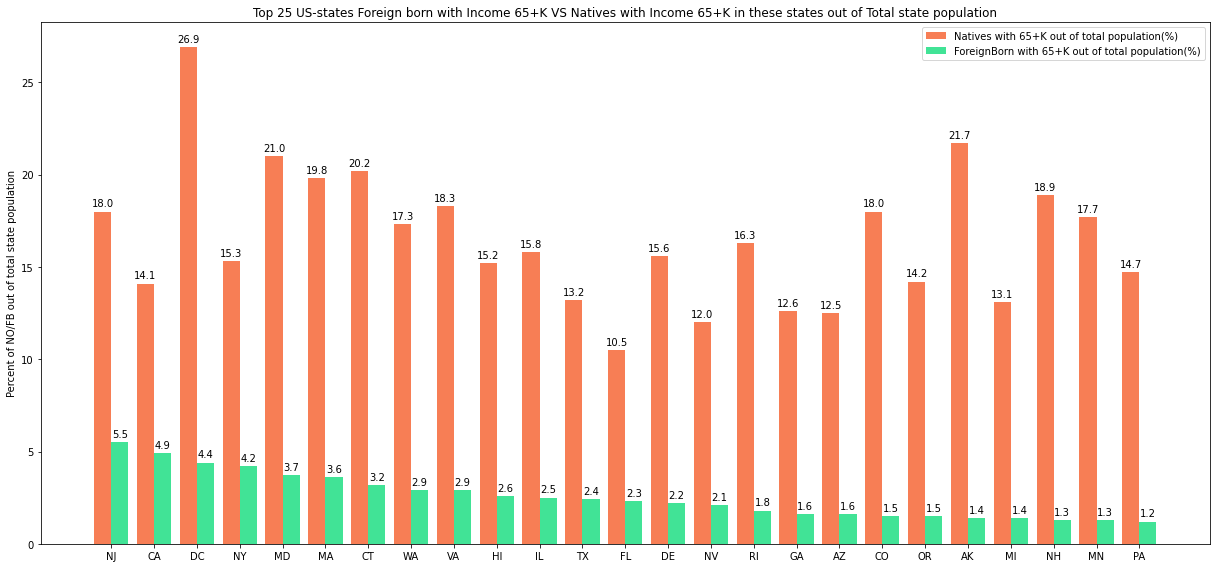


 20 US-states with the highest percentage of 'With Income' for ALL_citizens and for FB_only: 
                    State State_code State_abbr       Total  With_Income    35_50_K    50_65_K    65_75_K   75K_More    FB_Total  FB_With_Income  FB_35_50_K  FB_50_65_K  FB_65_75_K  FB_75K_More    NO_total  NO_With_Income  With_Income_All_%  NO_With_Income_from_All_%  FB_With_Income_from_All_%  With_Income_FB_from_FB%  With_Income_NO_from_NO%  NO_35_50_K  NO_50_65_K  NO_65_75_K  NO_75K_More  NO_65_More_from_All%  FB_65K_More_from_All%  NO_65_More_from_NO%  FB_65K_More_from_FB%  NO_35_50_K_from_NO%  NO_50_65_K_from_NO%  NO_65_75_K_from_NO%  NO_75K_More_from_NO%  FB_35_50_K_from_FB%  FB_50_65_K_from_FB%  FB_65_75_K_from_FB%  FB_75K_More_from_FB%
8   District of Columbia         11         DC  5.6988e+05   5.0545e+05    55405.0    51917.0    27421.0   151316.0  9.0482e+04         78976.0      9561.0      7185.0      3741.0      21461.0  4.7940e+05      4.2648e+05             0.8869              

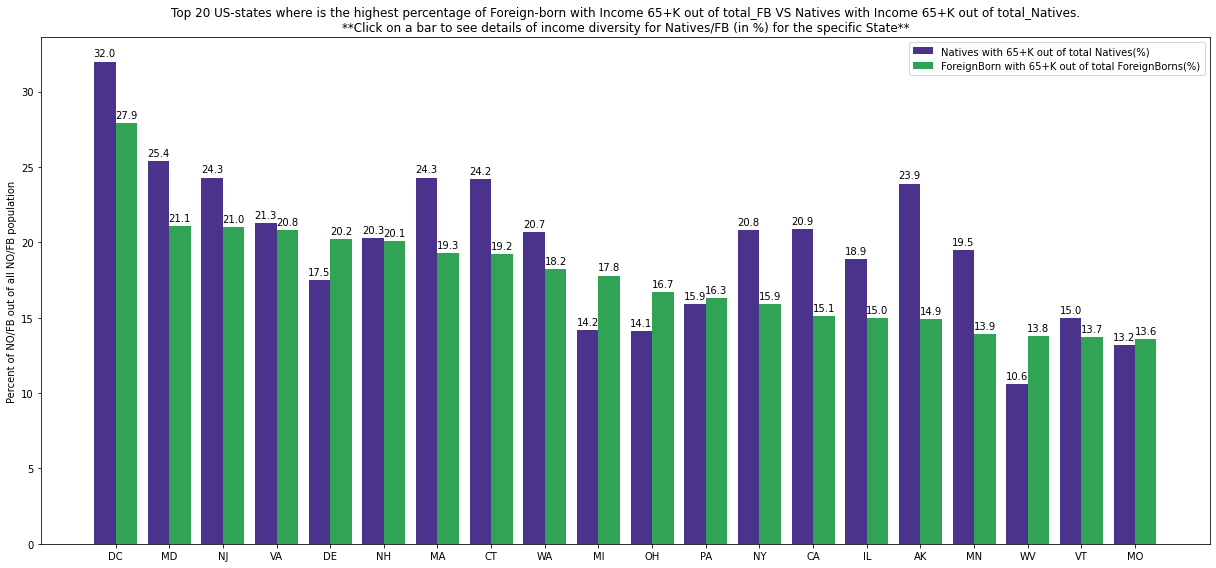

In [8]:
# Q1: Building of 'FB_vs_Native_States_Income':
print("Q1: States Income: Foreign born vs. Natives.\nClose graphs to allow the program to continue running.")
FB_vs_Native_States_Income = ForeingBorn_vs_Native_Incomes_by_states_2017_with_graph()

In [9]:
# Q2: Building of 'StatesCitizenship2017':
print("Q2:Is there any difference between the absorption of the population in different US-states?\nPlease wait till Map-graph will appear...")
StatesCitizenship2017 = CitizenshipNaturalization_from_StatePopulation_2017_with_graph()

Q2:Is there any difference between the absorption of the population in different US-states?
Please wait till Map-graph will appear...

AVG Percent of all Foreign Born citizens of US = 0.134
Significant difference: 
	['CA', 'NY', 'NJ', 'FL', 'NV', 'HI', 'TX', 'MA', 'MD', 'CT', 'DC', 'IL', 'WA', 'RI', 'VA', 'GA', 'OR', 'CO', 'NM', 'DE', 'UT', 'MN', 'NC', 'AK', 'KS', 'NE', 'MI', 'PA', 'ID', 'NH', 'OK', 'IN', 'IA', 'TN', 'WI', 'SC', 'AR', 'VT', 'OH', 'LA', 'MO', 'KY', 'ND', 'ME', 'WY', 'AL', 'SD', 'MS', 'MT', 'WV'] 
Insignificant difference: 
	['AZ']
Test
                    State  ...                                               text
5             California  ...  State: California<br>Total population: 3898284...
33              New York  ...  State: New York<br>Total population: 19798228....
31            New Jersey  ...  State: New Jersey<br>Total population: 8960161...
10               Florida  ...  State: Florida<br>Total population: 20278447.0...
30                Nevada  ...  State